In [50]:
import matplotlib
print(matplotlib.matplotlib_fname()) #設定ファイルを表示（matplotlibrcは後で作ります）
print(matplotlib.rcParams['font.family']) #現在使用しているフォントを表示
print(matplotlib.get_configdir()) #設定ディレクトリを表示
print(matplotlib.get_cachedir()) #キャッシュディレクトリを表示

# 基本ライブラリ
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 前処理用ライブラリ
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# モデル構築用ライブラリ（TensorFlow/Keras）
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, GRU, Dropout
from keras.callbacks import EarlyStopping
import keras.backend as K
from keras.regularizers import l2
from keras.models import Model
from keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D
from keras.callbacks import EarlyStopping
import keras.backend as K



# オプティマイザー
from keras.optimizers import Adam

plt.style.use('ggplot') #グラフのスタイル
plt.rcParams['figure.figsize'] = [12, 9] # グラフサイズ設定

/usr/local/lib/python3.9/site-packages/matplotlib/mpl-data/matplotlibrc
['sans-serif']
/root/.config/matplotlib
/root/.cache/matplotlib


In [138]:
all_df = pd.read_csv('../Predict_sales/csv/all_sales_data_2021-2024.csv', index_col=0)
all_df['Total Precipitation (mm)'] = all_df['Total Precipitation (mm)'].replace('--', 0).astype(float)

target_columns = ['Season_fall-winter_sum', 'Season_spring-fall_sum', 'Season_spring-summer_sum']

In [139]:
all_df = all_df.drop(['Quantity', 'Brand_Price_Range_Very Low', 'Brand_Price_Range_Low','Brand_Price_Range_Medium', 'Brand_Price_Range_High','Brand_Price_Range_Very High','Brand_Price_Range_Extremely High' ], axis=1)
all_df.columns

Index(['Season_fall-winter_sum', 'Season_spring-fall_sum',
       'Season_spring-summer_sum', 'TotalPrice', 'ShipCharge',
       'TotalMallCouponDiscount', 'Week_Friday', 'Week_Monday',
       'Week_Saturday', 'Week_Sunday', 'Week_Thursday', 'Week_Tuesday',
       'Week_Wednesday', 'Holiday_Flag', 'SaleEventFlag_yahoo',
       'SaleEventFlag_rakuten', 'Average_Temperature', 'Maximum Temperature',
       'Minimum Temperature', 'Total Precipitation (mm)', 'Category_Outer',
       'Category_Suit', 'Category_Tops', 'Category_Bottoms', 'Category_Dress',
       'Category_Accessory'],
      dtype='object')

In [140]:
# 訓練データとテストデータに分割
train =  all_df["2021-06-16":"2023-11-30"]
test = all_df["2023-12-01":"2024-03-29"]

# 標準化
scaler = MinMaxScaler(feature_range=(0, 1))
train_sc = scaler.fit_transform(train)
test_sc = scaler.transform(test)  # 修正版

col_indices = [train.columns.get_loc(c) for c in target_columns]
col_indices

[0, 1, 2]

In [141]:
def create_dataset(dataset, look_back, target_indices):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        # 過去 look_back 日分の全特徴量をXに
        x = dataset[i : i + look_back, :]  # shape: (look_back, 全特徴量)
        # 目的変数は look_back 後の行から複数列をまとめて取得
        y = dataset[i + look_back, target_indices]  # shape: (3,) 
        dataX.append(x)
        dataY.append(y)
    return np.array(dataX), np.array(dataY)

look_back = 91  # 例: 91日分の履歴を入力

trainX, trainY = create_dataset(train_sc, look_back, col_indices)
testX, testY = create_dataset(test_sc, look_back, col_indices)

# trainX, trainY を作成した後、時系列の最後の20%を検証用に分割
val_size = int(len(trainX) * 0.2)

X_train = trainX[:-val_size]
Y_train = trainY[:-val_size]
X_val   = trainX[-val_size:]
Y_val   = trainY[-val_size:]


print("trainX:", trainX.shape)  # (サンプル数, 91, 特徴量数)
print("trainY:", trainY.shape)  # (サンプル数, 3)


trainX: (807, 91, 26)
trainY: (807, 3)


In [88]:
trainX.shape

(807, 91, 24)

In [142]:
K.clear_session()

model_rnn = Sequential()
model_rnn.add(SimpleRNN(128, return_sequences=True, 
                        input_shape=(X_train.shape[1], X_train.shape[2])))
model_rnn.add(Dropout(0.2))
model_rnn.add(SimpleRNN(64))
model_rnn.add(Dropout(0.2))

# 多出力 → Dense(3)
model_rnn.add(Dense(3))

model_rnn.compile(loss='mean_squared_error', optimizer='adam')
model_rnn.summary()

early_stop_rnn = EarlyStopping(monitor='val_loss', 
                               patience=10, 
                               verbose=1, 
                               restore_best_weights=True)

history_rnn = model_rnn.fit(
    X_train, Y_train,
    epochs=500,
    batch_size=32,
    verbose=2,
    validation_data=(X_val, Y_val),
    callbacks=[early_stop_rnn]
)


/usr/local/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 91, 128)        │        19,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 91, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 64)             │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,387 (126.51 KB)

 Trainable params: 32,387 (126.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
21/21 - 4s - 168ms/step - loss: 0.3201 - val_loss: 0.0548
Epoch 2/500
21/21 - 3s - 162ms/step - loss: 0.2352 - val_loss: 0.0375
Epoch 3/500
21/21 - 2s - 86ms/step - loss: 0.1804 - val_loss: 0.0418
Epoch 4/500
21/21 - 3s - 155ms/step - loss: 0.1490 - val_loss: 0.0353
Epoch 5/500
21/21 - 4s - 211ms/step - loss: 0.1281 - val_loss: 0.0317
Epoch 6/500
21/21 - 2s - 91ms/step - loss: 0.1097 - val_loss: 0.0306
Epoch 7/500
21/21 - 3s - 125ms/step - loss: 0.0869 - val_loss: 0.0192
Epoch 8/500
21/21 - 2s - 82ms/step - loss: 0.0752 - val_loss: 0.0204
Epoch 9/500
21/21 - 3s - 158ms/step - loss: 0.0667 - val_loss: 0.0170
Epoch 10/500
21/21 - 2s - 110ms/step - loss: 0.0611 - val_loss: 0.0175
Epoch 11/500
21/21 - 2s - 76ms/step - loss: 0.0541 - val_loss: 0.0169
Epoch 12/500
21/21 - 2s - 91ms/step - loss: 0.0482 - val_loss: 0.0150
Epoch 13/500
21/21 - 3s - 156ms/step - loss: 0.0418 - val_loss: 0.0140
Epoch 14/500
21/21 - 6s - 264ms/step - loss: 0.0392 - val_loss: 0.0140
Epoch 15/500
21/21 -

In [ ]:
from keras.layers import LSTM

K.clear_session()

model_lstm = Sequential()
model_lstm.add(LSTM(64, dropout=0.3, recurrent_dropout=0.3,
                    input_shape=(X_train.shape[1], X_train.shape[2])))
model_lstm.add(Dense(3))

model_lstm.compile(loss='mean_squared_error', optimizer='adam')
model_lstm.summary()

early_stop_lstm = EarlyStopping(monitor='val_loss', 
                                patience=10, 
                                verbose=1, 
                                restore_best_weights=True)

history_lstm = model_lstm.fit(
    X_train, Y_train,
    epochs=500,
    batch_size=32,
    verbose=2,
    validation_data=(X_val, Y_val),
    callbacks=[early_stop_lstm]
)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 128)            │        82,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 82,819 (323.51 KB)

 Trainable params: 82,819 (323.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000
26/26 - 4s - 164ms/step - loss: 0.0109
Epoch 2/1000
26/26 - 2s - 80ms/step - loss: 0.0089
Epoch 3/1000
26/26 - 2s - 62ms/step - loss: 0.0087
Epoch 4/1000
26/26 - 2s - 90ms/step - loss: 0.0088
Epoch 5/1000
26/26 - 3s - 133ms/step - loss: 0.0084
Epoch 6/1000
26/26 - 2s - 59ms/step - loss: 0.0085
Epoch 7/1000
26/26 - 4s - 137ms/step - loss: 0.0085
Epoch 8/1000
26/26 - 5s - 208ms/step - loss: 0.0085
Epoch 9/1000
26/26 - 3s - 107ms/step - loss: 0.0083
Epoch 10/1000
26/26 - 3s - 105ms/step - loss: 0.0083
Epoch 11/1000
26/26 - 6s - 221ms/step - loss: 0.0080
Epoch 12/1000
26/26 - 3s - 106ms/step - loss: 0.0081
Epoch 13/1000
26/26 - 3s - 102ms/step - loss: 0.0083
Epoch 14/1000
26/26 - 6s - 220ms/step - loss: 0.0079
Epoch 15/1000
26/26 - 3s - 125ms/step - loss: 0.0079
Epoch 16/1000
26/26 - 4s - 170ms/step - loss: 0.0078
Epoch 17/1000
26/26 - 4s - 162ms/step - loss: 0.0077
Epoch 18/1000
26/26 - 5s - 176ms/step - loss: 0.0079
Epoch 19/1000
26/26 - 3s - 135ms/step - loss: 0.0078
Epoch 

In [129]:
K.clear_session()

input_shape = (trainX.shape[1], trainX.shape[2])
inputs = Input(shape=input_shape)

# Attention層
attention_out = MultiHeadAttention(num_heads=2, key_dim=8)(inputs, inputs)
attention_out = LayerNormalization(epsilon=1e-6)(attention_out + inputs)

# Feed Forward Network層（正則化 + Dropout）
ffn = Dense(16, activation='relu', kernel_regularizer=l2(0.005))(attention_out)
ffn = Dropout(0.5)(ffn)
ffn = Dense(trainX.shape[2], kernel_regularizer=l2(0.005))(ffn)
ffn_out = LayerNormalization(epsilon=1e-6)(ffn + attention_out)

# プーリングで次元圧縮
gap = GlobalAveragePooling1D()(ffn_out)

# 多出力 → Dense(3)
outputs = Dense(3)(gap)

optimizer = Adam(learning_rate=0.0001)
transformer_model = Model(inputs=inputs, outputs=outputs)
transformer_model.compile(loss='mean_squared_error', optimizer=optimizer)
transformer_model.summary()

early_stop_trans = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_transformer = transformer_model.fit(
    trainX, trainY,
    epochs=500,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop_trans],
    verbose=2
)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 91, 32)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 91, 32)    │      2,128 │ input_layer[0][0… │
│ (MultiHeadAttentio… │                   │            │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 91, 32)    │          0 │ multi_head_atten… │
│                     │                   │            │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 91, 32)    │         64 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 91, 16)    │        528 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 91, 16)    │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 91, 32)    │        544 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 91, 32)    │          0 │ dense_1[0][0],    │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 91, 32)    │         64 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 32)        │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 3)         │         99 │ global_average_p… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,427 (13.39 KB)

 Trainable params: 3,427 (13.39 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
21/21 - 5s - 228ms/step - loss: 1.8164 - val_loss: 2.4808
Epoch 2/500
21/21 - 2s - 76ms/step - loss: 1.3258 - val_loss: 1.8011
Epoch 3/500
21/21 - 1s - 51ms/step - loss: 0.9610 - val_loss: 1.2730
Epoch 4/500
21/21 - 1s - 32ms/step - loss: 0.6842 - val_loss: 0.8862
Epoch 5/500
21/21 - 1s - 25ms/step - loss: 0.4922 - val_loss: 0.6206
Epoch 6/500
21/21 - 1s - 38ms/step - loss: 0.3704 - val_loss: 0.4487
Epoch 7/500
21/21 - 0s - 22ms/step - loss: 0.3016 - val_loss: 0.3477
Epoch 8/500
21/21 - 0s - 19ms/step - loss: 0.2635 - val_loss: 0.2924
Epoch 9/500
21/21 - 1s - 46ms/step - loss: 0.2462 - val_loss: 0.2655
Epoch 10/500
21/21 - 1s - 27ms/step - loss: 0.2386 - val_loss: 0.2523
Epoch 11/500
21/21 - 1s - 32ms/step - loss: 0.2346 - val_loss: 0.2446
Epoch 12/500
21/21 - 1s - 47ms/step - loss: 0.2336 - val_loss: 0.2400
Epoch 13/500
21/21 - 0s - 14ms/step - loss: 0.2312 - val_loss: 0.2371
Epoch 14/500
21/21 - 0s - 14ms/step - loss: 0.2307 - val_loss: 0.2345
Epoch 15/500
21/21 - 0s - 14

In [ ]:
# RNN
pred_rnn = model_rnn.predict(testX)          # shape: (サンプル数, 3)

# LSTM
pred_lstm = model_lstm.predict(testX)        # shape: (サンプル数, 3)

# iTransformer
pred_transformer = transformer_model.predict(testX)  # shape: (サンプル数, 3)

# 実測値
y_true = testY  # shape: (サンプル数, 3)

# それぞれの列を取り出して評価 (例)
# 例えば 0: 'Season_fall-winter_sum', 1: 'Season_spring-fall_sum', 2: 'Season_spring-summer_sum'
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

for i, target_name in enumerate(target_columns):
    #=== RNN ===
    mse_rnn = mean_squared_error(y_true[:, i], pred_rnn[:, i])
    rmse_rnn = np.sqrt(mse_rnn)
    mae_rnn = mean_absolute_error(y_true[:, i], pred_rnn[:, i])
    
    #=== LSTM ===
    mse_lstm = mean_squared_error(y_true[:, i], pred_lstm[:, i])
    rmse_lstm = np.sqrt(mse_lstm)
    mae_lstm = mean_absolute_error(y_true[:, i], pred_lstm[:, i])
    
    #=== Transformer ===
    mse_trans = mean_squared_error(y_true[:, i], pred_transformer[:, i])
    rmse_trans = np.sqrt(mse_trans)
    mae_trans = mean_absolute_error(y_true[:, i], pred_transformer[:, i])

    print(f"=== {target_name} ===")
    print(f" RNN         | MSE={mse_rnn:.5f} | RMSE={rmse_rnn:.5f} | MAE={mae_rnn:.5f}")
    print(f" LSTM        | MSE={mse_lstm:.5f} | RMSE={rmse_lstm:.5f} | MAE={mae_lstm:.5f}")
    print(f" Transformer | MSE={mse_trans:.5f} | RMSE={rmse_trans:.5f} | MAE={mae_trans:.5f}")
    print("---------------------")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.0147
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
Transformer Test Loss (MSE): 0.0147
Transformer RMSE: 0.0642
Transformer MAE: 0.0424


In [133]:
# RNN
pred_rnn = model_rnn.predict(testX)          # shape: (サンプル数, 3)

# LSTM
pred_lstm = model_lstm.predict(testX)        # shape: (サンプル数, 3)

# iTransformer
pred_transformer = transformer_model.predict(testX)  # shape: (サンプル数, 3)

print(pred_rnn)
print(pred_lstm)
print(pred_transformer)

# 実測値
y_true = testY  # shape: (サンプル数, 3)

for i, target_name in enumerate(target_columns):
    #=== RNN ===
    mse_rnn = mean_squared_error(y_true[:, i], pred_rnn[:, i])
    rmse_rnn = np.sqrt(mse_rnn)
    mae_rnn = mean_absolute_error(y_true[:, i], pred_rnn[:, i])
    
    #=== LSTM ===
    mse_lstm = mean_squared_error(y_true[:, i], pred_lstm[:, i])
    rmse_lstm = np.sqrt(mse_lstm)
    mae_lstm = mean_absolute_error(y_true[:, i], pred_lstm[:, i])
    
    #=== Transformer ===
    mse_trans = mean_squared_error(y_true[:, i], pred_transformer[:, i])
    rmse_trans = np.sqrt(mse_trans)
    mae_trans = mean_absolute_error(y_true[:, i], pred_transformer[:, i])

    print(f"=== {target_name} ===")
    print(f" RNN         | MSE={mse_rnn:.5f} | RMSE={rmse_rnn:.5f} | MAE={mae_rnn:.5f}")
    print(f" LSTM        | MSE={mse_lstm:.5f} | RMSE={rmse_lstm:.5f} | MAE={mae_lstm:.5f}")
    print(f" Transformer | MSE={mse_trans:.5f} | RMSE={rmse_trans:.5f} | MAE={mae_trans:.5f}")
    print("---------------------")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
[[ 0.02812232 -0.01259821 -0.02530782]
 [ 0.00255588  0.04304828  0.01903637]
 [ 0.04675576  0.069796    0.07742389]
 [ 0.01976935  0.06186206  0.04031212]
 [ 0.16005303  0.1595245   0.11011229]
 [ 0.10280992  0.10899608  0.19204515]
 [ 0.11013452  0.15356687  0.14688265]
 [ 0.10706919  0.14707336  0.15214682]
 [ 0.13681023  0.15530697  0.12712654]
 [ 0.11751845  0.10920939  0.12330576]
 [ 0.12173327  0.11517898  0.16859876]
 [-0.05146626  0.00443543  0.03966907]
 [ 0.02361286  0.04470461  0.09154122]
 [ 0.02764192 -0.02987286  0.04500566]
 [ 0.04354053 -0.05735576  0.06796222]
 [ 0.02345612  0.04048303  0.08941857]
 [ 0.00578953  0.04391108  0.04203154]
 [ 0.06669984  0.1678376   0.09966135]
 [ 0.06705137  0.10303555  0.09739405]
 [ 0.09852891  0.07832052  0.09804949]
 [ 0.07290837  0.06839301  0.01845573]
 [ 0.02331389  0.12544978  0.03653838]
 [ 0.07073854  0.16607016  0

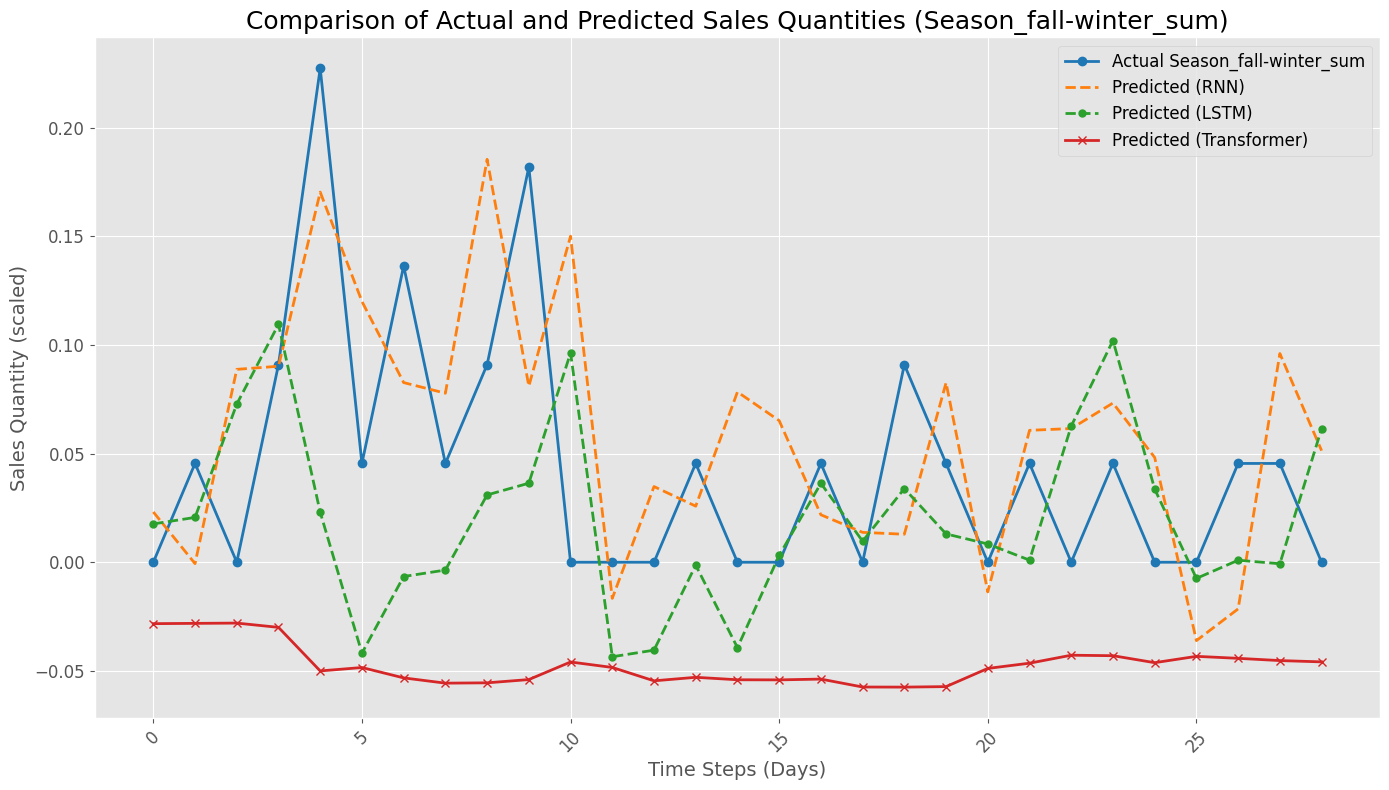

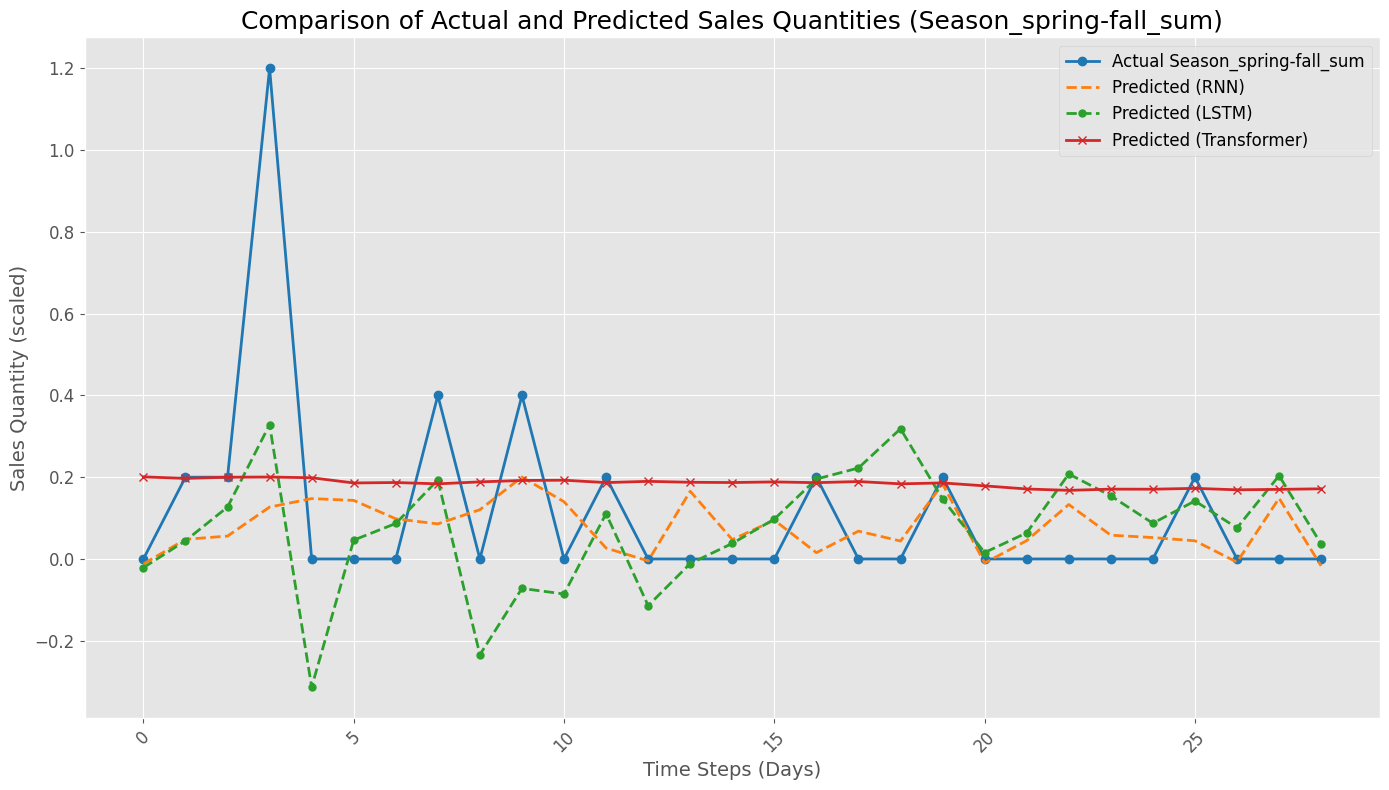

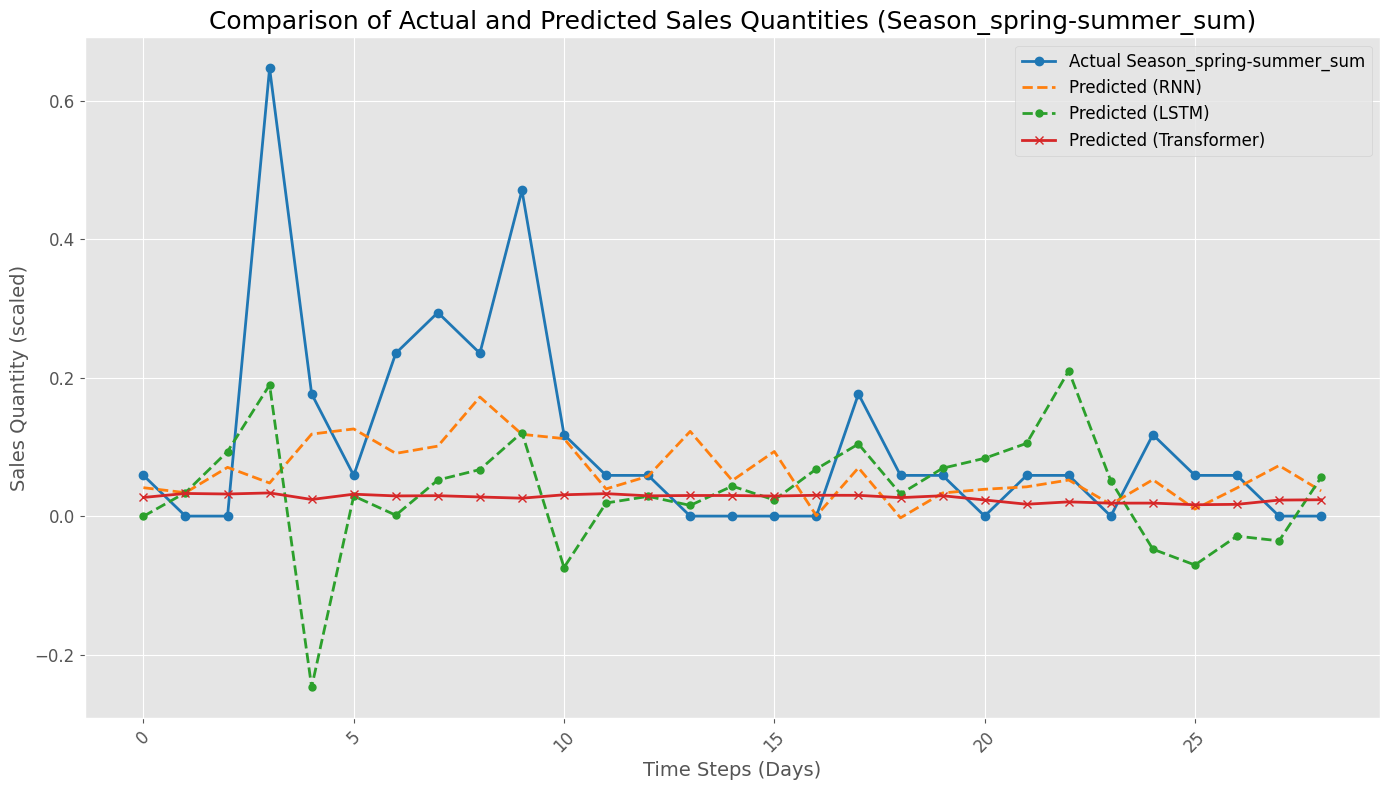

In [111]:
import matplotlib.pyplot as plt

# 目的変数の名称リスト（例）
target_names = ["Season_fall-winter_sum", "Season_spring-fall_sum", "Season_spring-summer_sum"]
y_test_actual = testY

# 目的変数の数だけループ
for i, name in enumerate(target_names):
    plt.figure(figsize=(14, 8))  # 各目的変数ごとに新しい図を作成
    
    # 実測値
    plt.plot(y_test_actual[:, i], color="#1f77b4", linewidth=2, marker='o', label=f"Actual {name}")
    
    # RNN予測値
    plt.plot(pred_rnn[:, i], color="#ff7f0e", linewidth=2, linestyle='--', label="Predicted (RNN)")
    
    # LSTM予測値
    plt.plot(pred_lstm[:, i], color="#2ca02c", linewidth=2, linestyle='--', marker='o', markersize=5, label="Predicted (LSTM)")
    
    # Transformer予測値
    plt.plot(pred_transformer[:, i], color="#d62728", linewidth=2, linestyle='-', marker='x', markersize=6, label="Predicted (Transformer)")
    
    # タイトルとラベルの設定
    plt.title(f"Comparison of Actual and Predicted Sales Quantities ({name})", fontsize=18)
    plt.xlabel("Time Steps (Days)", fontsize=14)
    plt.ylabel("Sales Quantity (scaled)", fontsize=14)
    
    # 凡例・グリッド
    plt.legend(fontsize=12, loc='upper right')
    plt.grid(True)
    
    # 軸ラベルのサイズ調整
    plt.xticks(fontsize=12, rotation=45)
    plt.yticks(fontsize=12)
    
    plt.tight_layout()
    plt.show()
